# Basic multi-agent simulation with steric interactions

In [28]:
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import copy

import jax.numpy as jnp
import jax
from jax import random
from jax import jit
from jax import vmap
from jax import lax
from jax.tree_util import register_pytree_node
import time
from typing import Tuple, Iterable
from functools import partial
from typing import NamedTuple, Any
import random as rm

from matplotlib.colors import Normalize
import matplotlib.cm as cm

import importlib
# Function for plots
import plotFns as pF
# Parameters in the model
import multPrmts as pR

In [29]:
colors = {
    "gray": {
        0: "#f8f9fa",
        1: "#f1f3f5",
        2: "#e9ecef",
        3: "#dee2e6",
        4: "#ced4da",
        5: "#adb5bd",
        6: "#868e96",
        7: "#495057",
        8: "#343a40",
        9: "#212529",
    },
    "red": {
        0: "#fff5f5",
        1: "#ffe3e3",
        2: "#ffc9c9",
        3: "#ffa8a8",
        4: "#ff8787",
        5: "#ff6b6b",
        6: "#fa5252",
        7: "#f03e3e",
        8: "#e03131",
        9: "#c92a2a",
    },
    "pink": {
        0: "#fff0f6",
        1: "#ffdeeb",
        2: "#fcc2d7",
        3: "#faa2c1",
        4: "#f783ac",
        5: "#f06595",
        6: "#e64980",
        7: "#d6336c",
        8: "#c2255c",
        9: "#a61e4d",
    },
    "grape": {
        0: "#f8f0fc",
        1: "#f3d9fa",
        2: "#eebefa",
        3: "#e599f7",
        4: "#da77f2",
        5: "#cc5de8",
        6: "#be4bdb",
        7: "#ae3ec9",
        8: "#9c36b5",
        9: "#862e9c",
    },
    "violet": {
        0: "#f3f0ff",
        1: "#e5dbff",
        2: "#d0bfff",
        3: "#b197fc",
        4: "#9775fa",
        5: "#845ef7",
        6: "#7950f2",
        7: "#7048e8",
        8: "#6741d9",
        9: "#5f3dc4",
    },
    "indigo": {
        0: "#edf2ff",
        1: "#dbe4ff",
        2: "#bac8ff",
        3: "#91a7ff",
        4: "#748ffc",
        5: "#5c7cfa",
        6: "#4c6ef5",
        7: "#4263eb",
        8: "#3b5bdb",
        9: "#364fc7",
    },
    "blue": {
        0: "#e7f5ff",
        1: "#d0ebff",
        2: "#a5d8ff",
        3: "#74c0fc",
        4: "#4dabf7",
        5: "#339af0",
        6: "#228be6",
        7: "#1c7ed6",
        8: "#1971c2",
        9: "#1864ab",
    },
    "cyan": {
        0: "#e3fafc",
        1: "#c5f6fa",
        2: "#99e9f2",
        3: "#66d9e8",
        4: "#3bc9db",
        5: "#22b8cf",
        6: "#15aabf",
        7: "#1098ad",
        8: "#0c8599",
        9: "#0b7285",
    },
    "teal": {
        0: "#e6fcf5",
        1: "#c3fae8",
        2: "#96f2d7",
        3: "#63e6be",
        4: "#38d9a9",
        5: "#20c997",
        6: "#12b886",
        7: "#0ca678",
        8: "#099268",
        9: "#087f5b",
    },
    "green": {
        0: "#ebfbee",
        1: "#d3f9d8",
        2: "#b2f2bb",
        3: "#8ce99a",
        4: "#69db7c",
        5: "#51cf66",
        6: "#40c057",
        7: "#37b24d",
        8: "#2f9e44",
        9: "#2b8a3e",
    },
    "lime": {
        0: "#f4fce3",
        1: "#e9fac8",
        2: "#d8f5a2",
        3: "#c0eb75",
        4: "#a9e34b",
        5: "#94d82d",
        6: "#82c91e",
        7: "#74b816",
        8: "#66a80f",
        9: "#5c940d",
    },
    "yellow": {
        0: "#fff9db",
        1: "#fff3bf",
        2: "#ffec99",
        3: "#ffe066",
        4: "#ffd43b",
        5: "#fcc419",
        6: "#fab005",
        7: "#f59f00",
        8: "#f08c00",
        9: "#e67700",
    },
    "orange": {
        0: "#fff4e6",
        1: "#ffe8cc",
        2: "#ffd8a8",
        3: "#ffc078",
        4: "#ffa94d",
        5: "#ff922b",
        6: "#fd7e14",
        7: "#f76707",
        8: "#e8590c",
        9: "#d9480f",
    },
    "mixed": {
        0: "#880e4f",
        1: "#1a237e",
        2: "#e65100",
        3: "#004d40",
        4: "#c92a2a",
    },
}

 ## <a class="anchor" id="first-bullet">Agents walking along semi-circular track by following pheromone</a>

In [30]:
p = pR.params()
xvec = np.linspace(-1.5*p.a, 1.5*p.a, p.nMsh)
xphm, yphm = np.meshgrid(xvec,
                         xvec)
cInit = np.zeros((p.nMsh, p.nMsh))
for ix in range(p.nMsh):
    for iy in range(p.nMsh):
        r = np.sqrt(xphm[ix][iy]**2+yphm[ix][iy]**2)
        if (r > (p.a-p.pt))  & (r < (p.a+p.pt)) & (yphm[ix][iy] >= 0):
            cInit[ix][iy] = 1.0
class phrmn():
    def __init__(self, cInit):
        super().__init__()
        self.c = cInit
        
# Interpolate value of pheromone to location r 
def phmChk(r, c):
    cVal = sp.interpolate.interp2d(xvec, xvec, c, kind='cubic')
    return cVal(r[0], r[1])
phm = phrmn(cInit)

In [31]:
phm = phrmn(cInit)
# Worker class
class worker():
    global phm
    def __init__(self, ptr):
        super().__init__()
        p = copy.deepcopy(ptr)
        self.r = p.rInit
        self.thet = p.thetInit
        
        #Worker variables
        self.dirCtrl = np.ones(p.nAgnts) #Controls direction of motion: 1 -  Anti-clockwise; -1 - Clockwise
        
    def wkPolicy(self, ptr): #worker policy
        p = copy.deepcopy(ptr)
        
        phi = np.arctan2(self.r[1], self.r[0])
        self.thet = phi + 0.5*np.pi*self.dirCtrl + np.random.uniform(-np.pi/5, np.pi/5, p.nAgnts)
        self.r += p.l*np.array([np.cos(self.thet), np.sin(self.thet)])
        
        #Makes sure that workers is within pheromone region
        fInd = np.where(np.linalg.norm(self.r, axis=0) > (p.a+p.pt-p.l))
        if np.size(fInd) > 0:
            self.thet[fInd] = self.thet[fInd] + self.dirCtrl[fInd]*np.pi*0.25
            self.r[0][fInd] += p.l*np.cos(self.thet[fInd])
            self.r[1][fInd] += p.l*np.sin(self.thet[fInd])
        fInd = np.where(np.linalg.norm(self.r, axis=0) < (p.a-p.pt+p.l))
        if np.size(np.where(np.linalg.norm(self.r, axis=0) < (p.a-p.pt))) > 0:    
            self.thet[fInd] = self.thet[fInd] - self.dirCtrl[fInd]*np.pi*0.25
            self.r[0][fInd] += p.l*np.cos(self.thet[fInd])
            self.r[1][fInd] += p.l*np.sin(self.thet[fInd])

        #Checks if target is reached and flip direction of motion
        clsChk = np.array([self.r[0] - p.tgt[0], self.r[1] - p.tgt[1]])
        fInd = np.where(np.linalg.norm(clsChk, axis=0) < 0.1)
        if np.size(fInd) > 0:
            self.dirCtrl[fInd] = -1.
        #Checks if home is reached and flip direction of motion
        clsChk = np.array([self.r[0] - p.strt[0], self.r[1] - p.strt[1]])
        fInd = np.where(np.linalg.norm(clsChk, axis=0) < 0.1)
        if np.size(fInd) > 0:
            self.dirCtrl[fInd] = 1.
    
    def reset(self, ptr):
        p = copy.deepcopy(ptr)
        self.r = p.rInit
        self.thet = p.thetInit
        self.dirCtrl = np.ones(p.nAgnts) #Controls direction of motion: 1 -  Anti-clockwise; -1 - Clockwise

In [32]:
# Forager class
class forager():
    global phm
    def __init__(self, ptr):
        super().__init__()
        p = copy.deepcopy(ptr)
        self.r = p.rFgInit #position of agent
        self.thet = p.thetFgInit #local orientation of agent
        self.rwd = 0.0 #reward collected
        self.sTrl = 0.0 #distance travelled by agent
        self.sInd = 0 #step count of agent
        self.valFn = np.zeros(p.nPtn) #value function initialized to zero
        self.phiSc = 0. #Angle at which bifurcation happens
        
    def intPolicy(self, ptr):
        p = copy.deepcopy(ptr)
        phi = np.arctan2(self.r[1], self.r[0])
        self.thet = phi + 0.5*np.pi + np.random.uniform(-np.pi/5, np.pi/5)
        self.r += p.l*np.array([np.cos(self.thet), np.sin(self.thet)])
        self.rwd += np.exp(-phi/p.phiSt)*p.l
        
        if np.linalg.norm(self.r) > (p.a+p.pt):
            self.thet = self.thet + np.pi*0.25
            self.r += p.l*np.array([np.cos(self.thet), np.sin(self.thet)])
            
        if np.linalg.norm(self.r) < (p.a-p.pt):
            self.thet = self.thet - np.pi*0.25
            self.r += p.l*np.array([np.cos(self.thet), np.sin(self.thet)])
    
    def ouPolicy(self, ptr):
        p = copy.deepcopy(ptr)
        self.r += p.l*np.array([np.cos(self.thet), np.sin(self.thet)])
        self.thet = self.thet*(1-p.nu*p.dt) + p.nu*p.dt*p.tgtPhi + np.sqrt(2*p.diff*p.dt)*np.random.normal()
        if np.linalg.norm(self.r - p.tgt) < p.sigma:
            self.rwd += (np.pi - self.phiSc)*p.a
            self.sInd = p.nSteps
        if np.linalg.norm(self.r) > (p.a+p.pt+0.1):
            self.sInd = p.nSteps
    
    def reset(self, ptr):
        p = copy.deepcopy(ptr)
        self.r = p.rInit #position of agent
        self.thet = p.thetInit #local orientation of agent
        self.rwd = 0.0 #reward collected
        self.sTrl = 0.0 #distance travelled by agent
        self.sInd = 0 #step count of agent

In [53]:
def repel(r1, r2, ptr):
    p = copy.deepcopy(ptr)
    r = np.hstack((r1, r2.reshape(2, p.nForag)))
    delta = (r[..., np.newaxis] - r[:, np.newaxis]).T
    distances = np.linalg.norm(delta, axis=-1)
    
    unit_vector = (delta.T / distances).T
    unit_vector[np.isnan(unit_vector)] = 0 # replace NaN values with 0
    
    charge_matrix = np.ones((p.nAgnts+p.nForag, p.nAgnts+p.nForag))
    force = 1e-3*charge_matrix / distances
    force[np.isinf(force)] = 0 # NaN forces are 0
    acc = (unit_vector.T * force).T.sum(axis=1)

    fInd = np.where(np.triu(distances) == 0.)
    distances[fInd] = 10.
    fInd = np.where(distances < (3*p.sz))
    fInd = np.unique(np.array(fInd).flatten())
    r[:,fInd] += p.dt*acc.T[:,fInd] ###Make it act only when distance is less than a limit
    return r[:,:p.nAgnts], r[:,p.nAgnts:p.nAgnts+p.nForag]

/var/folders/hq/qfn7h8h16pvdp93670td9g8w0000gn/T/ipykernel_72671/661043085.py:7: RuntimeWarning: invalid value encountered in divide
  unit_vector = (delta.T / distances).T
/var/folders/hq/qfn7h8h16pvdp93670td9g8w0000gn/T/ipykernel_72671/661043085.py:11: RuntimeWarning: divide by zero encountered in divide
  force = 1e-3*charge_matrix / distances


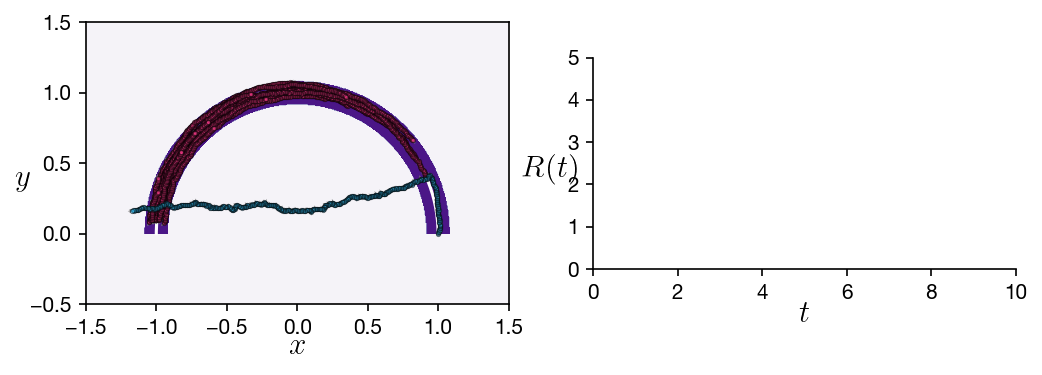

--- 0.4649467468261719 seconds ---


In [56]:
p = pR.params()
wk = worker(p)
fg = forager(p)

start_time = time.time()
# Worker data
rxFull = np.array(p.rInit[0])
ryFull = np.array(p.rInit[1])
phxFull = np.array(np.cos(p.thetInit))
phyFull = np.array(np.sin(p.thetInit))
# Forager data
rfgxFull = np.array(p.rFgInit[0])
rfgyFull = np.array(p.rFgInit[1])
phfgxFull = np.array(np.cos(p.thetFgInit))
phfgyFull = np.array(np.sin(p.thetFgInit))
while fg.sInd <= p.nSteps:
    wk.wkPolicy(p)
    if fg.sInd < p.nSc:
        fg.intPolicy(p)
    elif fg.sInd == p.nSc:
        tgtOrn = (p.tgt - fg.r)/np.linalg.norm(p.tgt - fg.r) #Orientation of the target from given location
        p.tgtPhi = np.arctan2(tgtOrn[1], tgtOrn[0])
        p.diff = p.diffCst/(np.pi - np.arctan2(fg.r[1],fg.r[0]))
        fg.ouPolicy(p)
    else:
        fg.ouPolicy(p)
    fg.sTrl += p.l
    fg.sInd += 1
    

    [wk.r, fg.r] = repel(wk.r, fg.r, p)
    fg.r = fg.r.reshape(2,)
    
        
    rxFull = np.vstack((rxFull, np.array(wk.r[0])))
    rfgxFull = np.vstack((rfgxFull, np.array(fg.r[0])))
    ryFull = np.vstack((ryFull, np.array(wk.r[1])))
    rfgyFull = np.vstack((rfgyFull, np.array(fg.r[1])))
    phxFull = np.vstack((phxFull, np.array(np.cos(wk.thet))))
    phfgxFull = np.vstack((phfgxFull, np.array(np.cos(fg.thet))))
    phyFull = np.vstack((phyFull, np.array(np.sin(wk.thet))))
    phfgyFull = np.vstack((phfgyFull, np.array(np.sin(fg.thet))))

importlib.reload(pF)
fix, ax = pF.plotDefMul(p, xphm, yphm, phm)
pF.plotMultAgt(fix, ax, p, rxFull, ryFull, phxFull, phyFull, 0.5)
pF.plotMultFg(fix, ax, p, rfgxFull, rfgyFull, phfgxFull, phfgyFull, 0.5)
plt.show()
print("--- %s seconds ---" % (time.time() - start_time))

In [21]:
importlib.reload(pF)
# pF.plotVidFn(p, xphm, yphm, phm, rxFull, ryFull, phxFull, phyFull)
pF.plotMulVidFn(p, xphm, yphm, phm, rxFull, ryFull, phxFull, phyFull, rfgxFull, rfgyFull, phfgxFull, phfgyFull)

! rm MultiAgent.mp4
! ffmpeg -r 10 -i "Multi%d.png" -c:v libx264 -vf fps=20 -pix_fmt yuv420p ./MultiAgent.mp4

IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

In [139]:
! rm Multi*.png